### Neural Diffusion Processes

In [1]:
import math
import einops
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
import torch.nn.functional as F
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Util codes

In [2]:
from scipy.spatial import distance

def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K

def np2torch(x_np,dtype=torch.float32,device='cpu'):
    x_torch = torch.tensor(x_np,dtype=dtype,device=device)
    return x_torch

def torch2np(x_torch):
    x_np = x_torch.detach().cpu().numpy() # ndarray
    return x_np

def gather_and_reshape(values,steps,x_shape):
    values_gather = torch.gather(input=values,dim=-1,index=steps.cpu())
    n_batch = steps.shape[0]
    out_shape = (n_batch,) + ((1,)*(len(x_shape)-1))
    values_gather_reshape = values_gather.reshape(shape=out_shape)
    return values_gather_reshape.to(steps.device)
    
print ("Ready")

Ready


`NDP` Equations 

Given state $s_t = (x_t, y_t)$, 

#### Forward diffusion process:
$$q(s_t|s_{t-1}) = \mathcal{N}\left(s_t; ~\sqrt{1-\beta_t}s_{t-1}, \beta_t I \right)$$

Due to fixed Markov chain $q(s_{0:T}) = q(s_0) \prod_{t=1}^T q(s_t | s_{t-1})$

Following satistified:
$$q(s_t|s_0) = \mathcal{N}\left( s_t; \sqrt{\bar{\alpha}_t} s_0, (1-\bar{\alpha}_t) I \right)$$ 
where $\bar{\alpha}_t = \prod_{s=1}^t (1-\beta_s)$

#### Reverse diffusion process posterior:
$$ 
q(s_{t-1}|s_t,s_0) 
= \mathcal{N}
\left(
s_{t-1}; \frac{\beta_t \sqrt{\bar{\alpha}_{t-1}}}{(1-\bar{\alpha}_t)} x_0
+
\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \sqrt{\alpha_t} x_t,
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)
$$

Approximating the mean with denosing model $\epsilon_\theta(s_t, t)$ it is possible to rewrite as backward kernel $p_\theta(s_{t-1} | s_t)$ as follows

$$
p_\theta(s_{t-1}|s_t) 
= \mathcal{N}
\left(
s_{t-1}; \frac{1}{\sqrt{\alpha_t}} (s_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta(s_t, t)),
\frac{\beta_t (1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}
\right)

$$

Default DDPM/NDP Regression Hyper-parameters:
$\beta_1 = 10^{-4}$, $\beta_T = 0.02$, $T=500$ 

Ready.


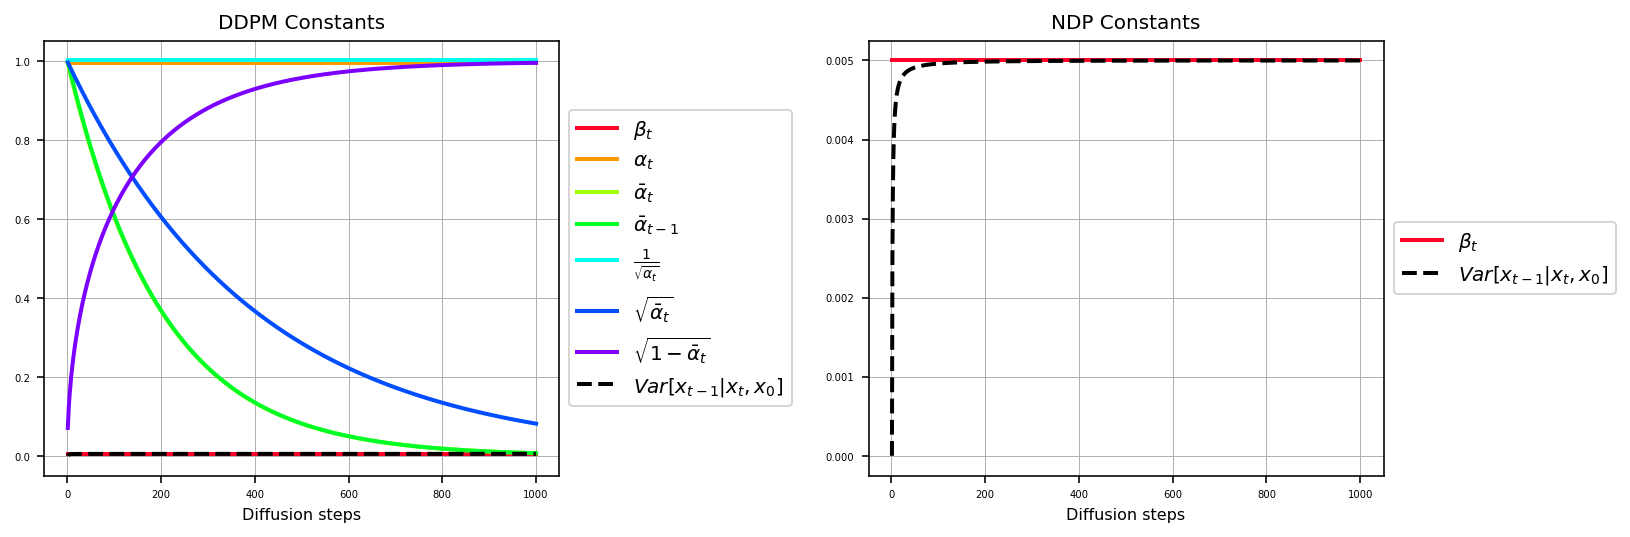

In [3]:
# Precompute some constants for NDP
dc = {}
dc['T'] = 1000
dc['betas'] = torch.linspace(start=0.005,end=0.005,steps=dc['T']) # [T]
dc['alphas'] = 1.0 - dc['betas'] # [T]
dc['alphas_bar'] = torch.cumprod(dc['alphas'],axis=0) # [T]
dc['alphas_bar_prev'] = torch.nn.functional.pad(dc['alphas_bar'][:-1],pad=(1,0),value=1.0) # [T]
dc['sqrt_recip_alphas'] = torch.sqrt(1.0/dc['alphas']) # [T]
dc['sqrt_alphas_bar'] = torch.sqrt(dc['alphas_bar']) # [T]
dc['sqrt_one_minus_alphas_bar'] = torch.sqrt(1.0-dc['alphas_bar']) # [T]
dc['posterior_variance'] = dc['betas']*(1.0-dc['alphas_bar_prev'])/(1.0-dc['alphas_bar']) # [T]
print ("Ready.")
# Plot
ts = np.linspace(start=1,stop=dc['T'],num=dc['T'])
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,8)]
lw = 2 # linewidth
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas']),color=cs[1],label=r'$\alpha_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar']),color=cs[2],label=r'$\bar{\alpha}_t$',lw=lw)
plt.plot(ts,torch2np(dc['alphas_bar_prev']),color=cs[3],label=r'$\bar{\alpha}_{t-1}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_recip_alphas']),color=cs[4],label=r'$\frac{1}{\sqrt{\alpha_t}}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_alphas_bar']),color=cs[5],label=r'$\sqrt{\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['sqrt_one_minus_alphas_bar']),color=cs[6],label=r'$\sqrt{1-\bar{\alpha}_t}$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('DDPM Constants',fontsize=10); plt.grid(lw=0.5);
plt.subplot(1,2,2)
plt.plot(ts,torch2np(dc['betas']),color=cs[0],label=r'$\beta_t$',lw=lw)
plt.plot(ts,torch2np(dc['posterior_variance']),'--',color='k',label=r'$ Var[x_{t-1}|x_t,x_0] $',lw=lw)
plt.xlabel('Diffusion steps',fontsize=8)
plt.legend(fontsize=10,loc='center left',bbox_to_anchor=(1,0.5))
plt.title('NDP Constants',fontsize=10); plt.grid(lw=0.5); 
plt.subplots_adjust(wspace=0.6); plt.show()

### `Algorithm 1` Training
1: $\mathbf{x}_0 \sim q( \mathbf{x}_0 )$, $\phi \sim p_\phi$, $\mathbf{y}_0 \sim \mathcal{N}(\mathbf{0}, k_\phi(\mathbf{x}_0, \mathbf{x}_0) + \sigma^2 \mathbf{I})$\
2: $\bar{\alpha_t} = \prod_{s=1}^t(1-\beta_s)$, $\gamma_t = \sqrt{1 - \bar{\alpha_t}}$, and $t \sim \text{Uniform}(\{ 1, \ldots, T \})$,\
3: $ \boldsymbol{\color{red} \epsilon_x, \color{blue} \epsilon_y} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \

$\bold{Case 1}$: If only diffuse on the observations, \
4: $\mathbf{y}_t = \sqrt{\bar{\alpha}} \mathbf{y}_0 + \gamma_t \boldsymbol{\color{blue}\epsilon_y}$ \
5: Take gradient descent step on the observation
$$ 
    \nabla \| \boldsymbol{\color{blue} \epsilon_y} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{blue} \epsilon_y}, t
        ) \|^2
$$
$\bold{Case 2}$: If diffuse both on sample and observations,\
4: $\mathbf{y}_t = \sqrt{\bar{\alpha}} \mathbf{y}_0 + \gamma_t \boldsymbol{\color{blue}\epsilon_y}$, and  $\mathbf{x}_t = \sqrt{\bar{\alpha_t}}\mathbf{x}_0 + \gamma_t \boldsymbol{\color{red} \epsilon_x} $ \
5: Take gradient descent step on both input and observations

$$ 
    \nabla \left[ \| \boldsymbol{\color{red} \epsilon_x} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{red} \epsilon_x}, t
        ) \|^2
    + \| \boldsymbol{\color{blue} \epsilon_y} - \boldsymbol{\epsilon}_{\theta}(\mathbf{x}_0,
        \sqrt{\bar{\alpha}_t} \mathbf{y}_0 + \sqrt{1-\bar{\alpha}_t} \boldsymbol{\color{blue} \epsilon_y}, t
        ) \|^2 
    \right]
$$

## TODO: Fix prior sampling part for NDP
### `Algorithm 2` Sampling 
1: $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ \
2: for $t=T,\ldots,1$ do \
3: $\quad$ $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$ \
4: $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}}
        \left(
            \mathbf{x}_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}
            \boldsymbol{\epsilon}_{\theta}(\mathbf{x},t)
        \right)
        + \sigma_t \mathbf{z}
    $ \
5: end for \
6: return $\mathbf{x}_0$

### Forward diffusion sampler

In [4]:
def forward_hilbert_diffusion_sample(x_0,K_chols,steps,dc,noise_rate=1.0):
    """
        x_0: torch.Tensor [B x D x L]
        K_chols: torch.Tensor [D x L x L]
        steps: torch.Tensor [B]
        dc: dictionary
        noise_rate: float (0.0~1.0)
    """
    sqrt_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=steps,x_shape=x_0.shape) # [B x 1 x 1]
    x_t_mean = sqrt_alphas_bar_t * x_0 # [B x D x L]
    x_t_std = sqrt_one_minus_alphas_bar_t # [B x D x L]
    # Correlated noise sampling 
    noise = torch.randn_like(input=x_0) # [B x D x L]
    noise_expand = noise[:,:,:,None] # [B x D x L x 1]
    K_chols_torch_tile = torch.tile(input=K_chols,dims=(x_0.shape[0],1,1,1)) # [B x D x L x L]
    correlated_noise_permuted = K_chols_torch_tile @ noise_expand # [B x D x L x 1]
    correlated_noise_squeeze = correlated_noise_permuted.squeeze(dim=3) # [B x D x L]
    # Sample with correlated noise
    x_t = x_t_mean + noise_rate*x_t_std*correlated_noise_squeeze # [B x D x L]
    return x_t,correlated_noise_squeeze # [B x D x L]
print ("Ready.")

Ready.


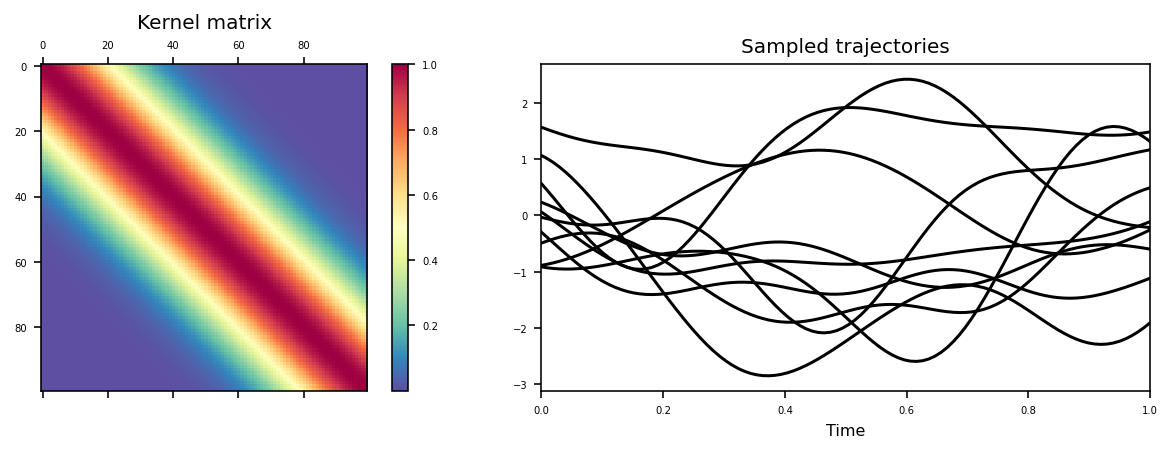

In [5]:
### Sample paths from GP prior
L = 100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
K = kernel_se(times,times,hyp={'gain':1.0,'len':1/4}) # [L x L]
K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
D = 10
trajs = np.random.randn(D,L) @ K_chol.T # [D x L]
# Plot
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.matshow(K,fignum=False,cmap=plt.cm.Spectral_r)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Kernel matrix',fontsize=10)
plt.subplot(1,2,2)
for d_idx in range(D):
    plt.plot(times[:,0],trajs[d_idx,:],ls='-',color='k') 
plt.xlim([0,1])
plt.title('Sampled trajectories',fontsize=10)
plt.xlabel('Time',fontsize=8); plt.show()

### Forward Hilbert diffusion sampling

In [6]:
B,D,L = 5,3,100 # #batch, length, dimension
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
K = kernel_se(times,times,hyp={'gain':1.0,'len':1/4}) # [L x L]
K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
x_0 = np2torch(np.random.randn(1,L) @ K_chol.T) # [1 x L]
x_0_batch = torch.tile(input=x_0[None,:,:],dims=(B,D,1)) # [B x D x L]
# Different length parameters per dimension
lens = [1,0.1,0.01]
K_chols_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    K = kernel_se(times,times,hyp={'gain':1.0,'len':lens[d_idx]})
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np) # [D x L x L]
# Forward sampling
steps = torch.linspace(start=0,end=dc['T']-1,steps=B).type(torch.long) # [B]
x_t,noise = forward_hilbert_diffusion_sample(
    x_0=x_0_batch,K_chols=K_chols,steps=steps,dc=dc,noise_rate=1.0)
# x_t:[B x D x L] / noise:[B x D x L]
print ("B:[%d] D:[%d] L:[%d]"%(B,D,L))
print ("x_t:%s noise:%s"%(x_t.shape,noise.shape))
print ("Forward sampling done.")

B:[5] D:[3] L:[100]
x_t:torch.Size([5, 3, 100]) noise:torch.Size([5, 3, 100])
Forward sampling done.


### Plot correlated noise and forward sampling results

In [7]:
x_0.shape

torch.Size([1, 100])

Plot correlated noises.


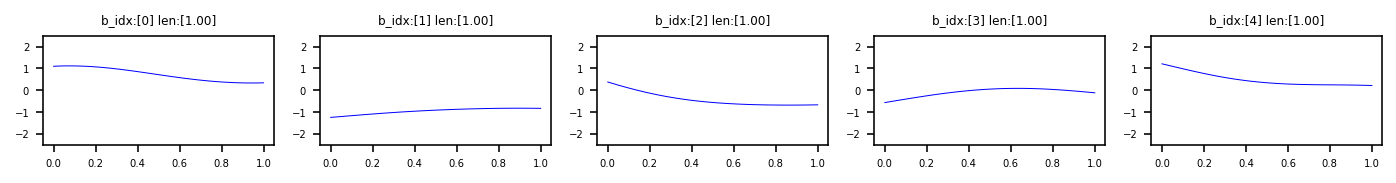

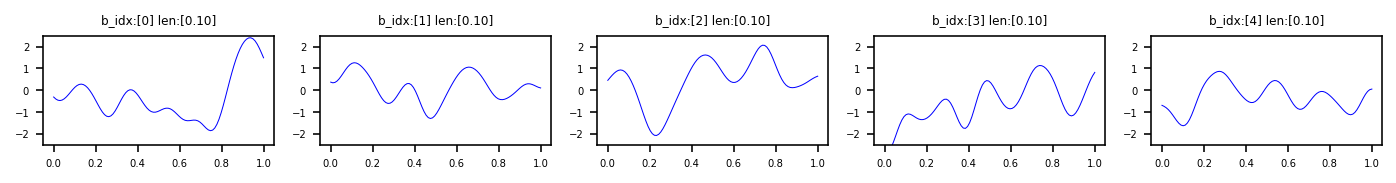

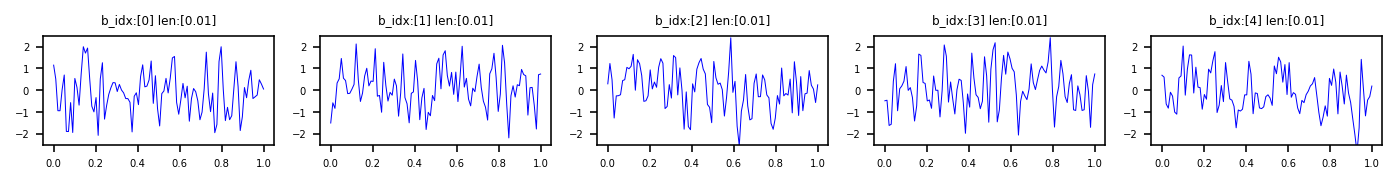

Plot forward sampling results.


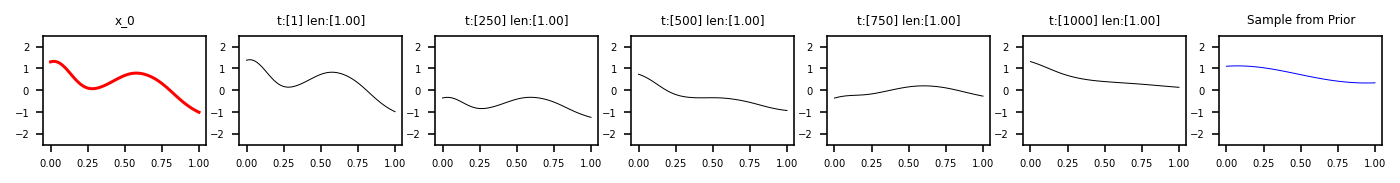

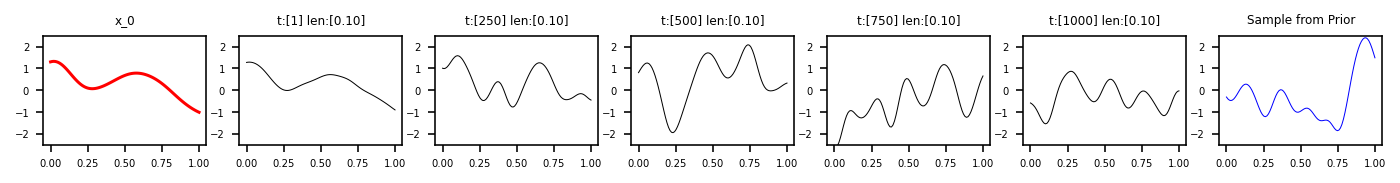

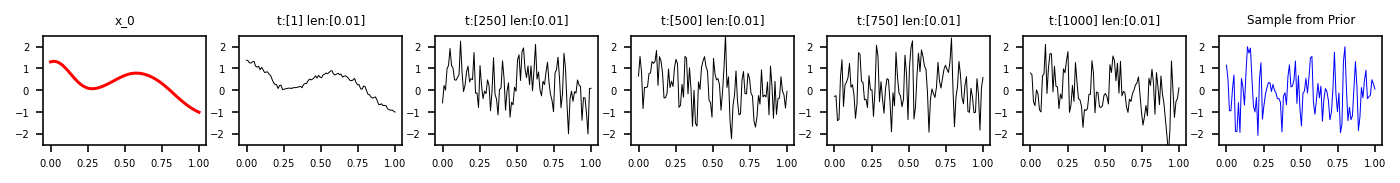

In [8]:
print ("Plot correlated noises.")
for d_idx in range(D):
    plt.figure(figsize=(12,1))
    for b_idx in range(B):
        plt.subplot(1,B,b_idx+1)
        plt.plot(times[:,0],noise[b_idx,d_idx,:],ls='-',color='b',lw=1/2)
        plt.ylim([-2.5,+2.5])
        plt.title('b_idx:[%d] len:[%.2f]'%(b_idx,lens[d_idx]),
                  fontsize=6)
    plt.show()
print ("Plot forward sampling results.")

for d_idx in range(D):
    plt.figure(figsize=(12,1))
    plt.subplot(1,B+2,1); plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='r')
    plt.ylim([-2.5,+2.5]); plt.title('x_0',fontsize=6)
    for b_idx in range(B):
        plt.subplot(1,B+2,b_idx+2); plt.plot(times[:,0],x_t[b_idx,d_idx,:],ls='-',color='k',lw=1/2)
        plt.ylim([-2.5,+2.5])
        plt.title('t:[%d] len:[%.2f]'%(torch2np(steps)[b_idx]+1,lens[d_idx]),
                  fontsize=6)
    plt.subplot(1,B+2,B+2); plt.plot(times,torch2np(noise[0,d_idx,:]),ls='-',color='b',lw=1/2)
    plt.ylim([-2.5,+2.5]); plt.title('Sample from Prior',fontsize=6); plt.show()

### Network - Deprecated (Implemented before the official code releases)

In [18]:
class TimeEmbeddingClass(nn.Module):
    def __init__(self, dim=128, T=1000):
        super().__init__()
        self.dim = dim
        self.T = T

    @torch.no_grad()
    def forward(self,steps=torch.arange(start=0,end=1000,step=1)):
        device = steps.device
        half_dim = self.dim // 2

        embeddings = torch.pow(10, torch.arange(half_dim, device=device, dtype=torch.float32) * 4 / (half_dim - 1))
        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class PreprocessClass(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.embedding = nn.Linear(2, hidden_dim)
    
    @torch.no_grad()
    def forward(self, x, y):
        D = x.shape[-1]
        x = x.unsqueeze(-1) 
        y = torch.repeat_interleave(y.unsqueeze(-1), D, axis=2)
        conc = torch.cat([x, y], dim=-1)
        s = self.embedding(conc)

        return s

class MultiHeadSelfAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads  = num_heads
        head_dim        = dim // num_heads
        self.scale      = head_dim ** -0.5
        
        # self.q          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.k          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.v          = nn.Linear(dim, dim, bias=qkv_bias)
        self.qkv        = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop  = nn.Dropout(attn_drop)
        self.proj       = nn.Linear(dim, dim)
        self.proj_drop  = nn.Dropout(proj_drop)        

    def forward(self, s):
        
        B, N, D, H = s.shape
        qkv = self.qkv(s).reshape(B, N, D, 3, self.num_heads, H//self.num_heads)
        # print(f'qkv size = {qkv.size()}')
        qkv = qkv.permute(3, 0, 4, 1, 2, 5)
        # print(f'qkv size = {qkv.size()}')
        q, k, v = qkv.unbind(0)
        # print(f'q size = {q.size()}, k size = {k.size()}, v size = {v.size()}')

        
        attn_score = (q @ k.transpose(-2, -1)) * self.scale
        # print(f'attention score size = {attn_score.size()}')
        attn_score = attn_score.softmax(dim=-1)
        attn_score = self.attn_drop(attn_score)

        # attention on dim D
        attn = (attn_score @ v).transpose(2, 3).reshape(B, N, D, H)
        # print(attn.size())
        attn = self.proj(attn)
        attn = self.proj_drop(attn)
        return attn

class BiDimensionalAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., norm = 'layernorm', activation='relu', pre_norm = True):
        super().__init__()
        self.MHSA_D = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)
        self.MHSA_N = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)

        self.norm = self._get_norm_layer(norm, dim)
        self.activation = self._get_act_fn(activation)
        self.pre_norm = pre_norm
        
        self.t_embed = nn.Linear(dim, dim)

    def forward(self, s, t):
        
        s_t = s + self.t_embed(t).unsqueeze(1).unsqueeze(2)

        if self.pre_norm:
            _s = self.norm(s_t)
            attn_d = self.MHSA_D(_s)
            attn_n = self.MHSA_N(_s.transpose(1, 2)).transpose(1, 2)
            a = attn_d + attn_n
            
        else:
            a = self.norm(self.MHSA_D(s_t) + self.MHSA_N(s_t.transpose(1, 2)).transpose(1, 2))

        a = self.activation(a)

        return a, a+s

    def _get_norm_layer(self, norm, dim):
        if norm.lower() == 'layernorm':
            return nn.LayerNorm(dim)
        elif norm.lower() == 'batchnorm':
            return nn.BatchNorm1d()
        else:
            raise NotImplementedError

    def _get_act_fn(self, activation):
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'silu':
            return nn.SiLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        else:
            raise NotImplementedError 


class NDPClass(nn.Module):
    def __init__(self,
                 name        = 'neural_diffusion_process',
                 D           = 3,
                 L           = 100,
                 pos_emb_dim = 128,
                 hidden_dim  = 64,
                 n_layers    = 5,
                 num_heads   = 8,
                 qkv_bias    = False,
                 attn_drop   = 0.,
                 proj_drop   = 0.,
                 norm        = 'layernorm',
                 activation  = 'relu',
                 pre_norm    = True,
                 actv        = nn.ReLU(),
                 RKHS_projs  = None,
                ):
        super().__init__()
        self.name        = name
        self.D           = D
        self.L           = L
        self.x_dim       = self.D * self.L
        self.pos_emb_dim = pos_emb_dim
        self.hidden_dim  = hidden_dim
        self.n_layers    = n_layers
        self.num_heads   = num_heads
        self.qkv_bias    = qkv_bias
        self.attn_drop   = attn_drop
        self.proj_drop   = proj_drop
        self.norm        = norm
        self.activation  = activation
        self.pre_norm    = pre_norm
        self.actv        = actv
        self.RKHS_projs  = RKHS_projs
        # Initialize layers
        self.init_layers()
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()
        # Bi-dimensional attention blocks
        for i in range(self.n_layers):
            self.layers['Attn_block_%02d'%(i)] = BiDimensionalAttentionClass(
                dim=self.hidden_dim, num_heads=self.num_heads, qkv_bias=self.qkv_bias,
                attn_drop=self.attn_drop, proj_drop=self.proj_drop, norm=self.norm,
                activation=self.activation, pre_norm=self.pre_norm)
        
        # Out
        self.layers['x_out'] = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1),)

        # Time embedding
        self.layers['Pos_Emb'] = nn.Sequential(
                TimeEmbeddingClass(dim=self.pos_emb_dim),
                nn.Linear(self.pos_emb_dim,self.hidden_dim),
                nn.GELU(),)
        
        # self.layers['Preprocess'] = PreprocessClass(self.hidden_dim)
        self.layers['Preprocess'] = nn.Linear(1, self.hidden_dim)

    def forward(self, x, y, t):
        """
            Forward
        """

        # s = self.layers['Preprocess'](x, y)
        s = self.layers['Preprocess'](x.unsqueeze(-1))
        pos_embed = self.layers['Pos_Emb'](t)   
        outs = torch.zeros_like(s)
        for i in range(self.n_layers):
            s_curr, s = self.layers['Attn_block_%02d'%(i)](s, pos_embed)
            outs += s_curr
        
        out = self.layers['x_out'](outs)
        net = out.squeeze(-1) # [B X L X D]

        # RKHS projection
        if self.RKHS_projs is not None:
            RKHS_projs_exapnd = self.RKHS_projs[None,:,:,:] # [1 x D x L x L]
            RKHS_projs_title = torch.tile(RKHS_projs_exapnd,dims=(net.shape[0],1,1,1)) # [B x D x L x L]
            net = net.reshape(-1,self.D,self.L) # [B x D x L]
            net = net[:,:,:,None]               # [B x D x L x 1]
            net = RKHS_projs_title.to(net.device) @ net        # [B x D x L x L] x [B x D x L x 1] => [B x D x L x 1]
            net = net.squeeze(dim=3)            # [B x D x L]
            # net = net.reshape(-1,self.D*self.L) # [B x DL]        
            net = net.transpose(1, 2)           # [B X L X D]

        return net # [B x L x D]

def get_ddpm_loss(model,x_0,K_chols,t,dc, device):
    """
        x_0: [B x D x L]
    """
    # Forward diffusion
    x_noisy,noise = forward_hilbert_diffusion_sample(
        x_0=x_0,K_chols=K_chols,steps=t,dc=dc,noise_rate=1.0) # [B x D x L]
    # Predict noise
    # TODO: NEED TO TRANSPOSE NOT RESHAPE
    x_noisy_flat = x_noisy.transpose(1, 2) # [B X L X D]
    noise_pred = model(x_noisy_flat.to(device), y=None, t=t.to(device)) # [B x L X D]
    # noise_pred = model(x_noisy_flat, t) # [B x DL]
    # Compute loss
    # TODO: NEED TO TRANSPOSE NOT RESHAPE
    noise_pred_unflat = noise_pred.transpose(1, 2).cpu() # [B X D X L]
    l1_loss = F.l1_loss(noise, noise_pred_unflat)
    l2_loss = F.mse_loss(noise, noise_pred_unflat)
    huber_loss = F.huber_loss(noise, noise_pred_unflat)
    loss = l2_loss
    return loss

print ("Ready")  

Ready.


### Network - Official code implemented in PyTorch with minor modifications from previous implementation

#### Notation
- N : the sequence length
- D : input dimension
- H : the hidden embedding dimension

In [9]:
class MultiHeadSelfAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads  = num_heads
        head_dim        = dim // num_heads
        self.scale      = head_dim ** -0.5

        # self.q          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.k          = nn.Linear(dim, dim, bias=qkv_bias)
        # self.v          = nn.Linear(dim, dim, bias=qkv_bias)
        self.qkv        = nn.Linear(dim, 3 * dim, bias=qkv_bias)
        self.attn_drop  = nn.Dropout(attn_drop)
        self.proj       = nn.Linear(dim, 2 * dim)
        self.proj_drop  = nn.Dropout(proj_drop)        

    def forward(self, s):
        
        B, N, D, H = s.shape
        qkv = self.qkv(s).reshape(B, N, D, 3, self.num_heads, H//self.num_heads)
        # print(f'qkv size = {qkv.size()}')
        qkv = qkv.permute(3, 0, 4, 1, 2, 5)
        # print(f'qkv size = {qkv.size()}')
        q, k, v = qkv.unbind(0)
        # print(f'q size = {q.size()}, k size = {k.size()}, v size = {v.size()}')

        
        attn_score = (q @ k.transpose(-2, -1)) * self.scale
        # print(f'attention score size = {attn_score.size()}')
        attn_score = attn_score.softmax(dim=-1)
        attn_score = self.attn_drop(attn_score)

        # attention on dim D
        attn = (attn_score @ v).transpose(2, 3).reshape(B, N, D, H)
        # print(attn.size())
        attn = self.proj(attn)
        attn = self.proj_drop(attn)
        return attn

class BiDimensionalAttentionClass(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., norm = 'layernorm', activation='relu', pre_norm = True):
        super().__init__()
        self.MHSA_D = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)
        self.MHSA_N = MultiHeadSelfAttentionClass(dim, num_heads, qkv_bias, attn_drop, proj_drop)

        self.norm = self._get_norm_layer(norm, dim)
        self.activation = self._get_act_fn(activation)
        self.pre_norm = pre_norm
        
        self.t_embed = nn.Linear(dim, dim)

    def forward(self, s, t):
    
        t = self.t_embed(t)[:, None, None, :] # ensure the shape of t should be [batch_size, 1, 1, H]
        s_t = s + t # ensure the shape of t should be [batch_size, N, D, H]

        # if self.pre_norm:
        #     _s = self.norm(s_t)
        #     attn_d = self.MHSA_D(_s)
        #     attn_n = self.MHSA_N(_s.transpose(1, 2)).transpose(1, 2)
        #     a = attn_d + attn_n
            
        # else:
        #     a = self.norm(self.MHSA_D(s_t) + self.MHSA_N(s_t.transpose(1, 2)).transpose(1, 2))

        # a = self.activation(a)
        # return a, a+s

        y_d = self.MHSA_D(s_t)
        y_n = self.MHSA_N(s_t.transpose(1, 2)).transpose(1, 2)

        a = y_d + y_n
        residual, skip = torch.tensor_split(a, 2, dim=-1)
        residual = self.activation(residual)
        skip = self.activation(skip)

        return (s + residual) / math.sqrt(2.0), skip


    def _get_norm_layer(self, norm, dim):
        if norm.lower() == 'layernorm':
            return nn.LayerNorm(dim)
        elif norm.lower() == 'batchnorm':
            return nn.BatchNorm1d()
        else:
            return nn.Identity()

    def _get_act_fn(self, activation):
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'silu':
            return nn.SiLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        else:
            raise NotImplementedError 


class NDPModel(nn.Module):
    def __init__(self,
                 name        = 'neural_diffusion_process_fixed',
                 D           = 3,
                 L           = 100,
                 pos_emb_dim = 128,
                 hidden_dim  = 64,
                 n_layers    = 5,
                 num_heads   = 8,
                 qkv_bias    = False,
                 attn_drop   = 0.,
                 proj_drop   = 0.,
                 norm        = 'layernorm',
                 activation  = 'relu',
                 pre_norm    = True,
                 actv        = nn.ReLU(),
                ):
        super().__init__()
        self.name        = name
        self.D           = D
        self.L           = L
        self.x_dim       = self.D * self.L
        self.pos_emb_dim = pos_emb_dim
        self.hidden_dim  = hidden_dim
        self.n_layers    = n_layers
        self.num_heads   = num_heads
        self.qkv_bias    = qkv_bias
        self.attn_drop   = attn_drop
        self.proj_drop   = proj_drop
        self.norm        = norm
        self.activation  = activation
        self.pre_norm    = pre_norm
        self.actv        = actv
        
        # Initialize layers
        self.init_layers()
        
    def init_layers(self):
        """
            Initialize layers
        """
        self.layers = nn.ModuleDict()

        # Preprocess embedding layer
        # If y as a prior is given
        # self.layers['Preprocess'] = nn.Sequential(
        #     nn.Linear(2, self.hidden_dim),
        #     nn.GELU(),
        # )
    
        # If only x is given
        self.layers['Preprocess'] = nn.Sequential(
            nn.Linear(1, self.hidden_dim),
            nn.GELU(),
        )

        # Bi-dimensional attention blocks
        for i in range(self.n_layers):
            self.layers['Attn_block_%02d'%(i)] = BiDimensionalAttentionClass(
                dim=self.hidden_dim, num_heads=self.num_heads, qkv_bias=self.qkv_bias,
                attn_drop=self.attn_drop, proj_drop=self.proj_drop, norm=self.norm,
                activation=self.activation, pre_norm=self.pre_norm)
        
        # Out
        self.layers['Out'] = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1, bias=False),)
        

    def forward(self, x, y, t):
        """
            Forward
        """
        s = self.prepcrocess(x, y) if y is not None else x.unsqueeze(-1)
        s = self.layers['Preprocess'](s)

        #TODO: check whether time embedding should be passed dense layer from pos_emb_dim -> hidden_dim
        t_embed = self.time_embed(t)

        # outs = torch.zeros_like(s)

        skip = None
        for i in range(self.n_layers):
            # s_curr, s = self.layers['Attn_block_%02d'%(i)](s, t_embed)
            s, skip_connection = self.layers['Attn_block_%02d'%(i)](s, t_embed)
            skip = skip_connection if skip is None else skip_connection + skip
            # outs += skip

        # out = self.layers['x_out'](outs)
        # return out.squeeze(-1)

        skip = einops.reduce(skip, "b n d h -> b n h", "mean")

        eps = skip / math.sqrt(self.n_layers * 1.0)
        eps = self.layers['Out'](eps)
        return eps
    
    
    def preprocess(self, x, y):
        D = x.shape[-1] # num x_dim
        x = x.unsqueeze(-1) 
        y = torch.repeat_interleave(y.unsqueeze(-1), D, axis=2)
        conc = torch.cat([x, y], dim=-1)

        return conc

    def time_embed(self, steps, max_positions=10000):
        '''
        steps: random time step t with shape (batch_size,)
        max_positions: log(10000) = 4
        '''
        device = steps.device
        # half_dim = self.pos_emb_dim // 2
        half_dim = self.hidden_dim // 2

        # Before the official code releases
        # embeddings = torch.pow(10, torch.arange(half_dim, device=device, dtype=torch.float32) * 4 / (half_dim - 1))
        # After the official code releases
        # emb = jnp.log(max_positions) / (half_dim - 1)
        embeddings = np.log(max_positions) / (half_dim - 1)
        # emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
        embeddings = torch.exp(torch.arange(half_dim, device=device, dtype=torch.float32) * -embeddings)

        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # if self.pos_emb_dim % 2 == 1:
        if self.hidden_dim % 2 == 1:
            embeddings = F.pad(embeddings, [[0, 0], [0, 1]])
        
        # assert embeddings.shape == (steps.shape[0], self.pos_emb_dim)
        assert embeddings.shape == (steps.shape[0], self.hidden_dim)
        return embeddings


print ("Ready.")    

Ready.


### Instantiate Dense U-net

In [10]:
model = NDPModel(D=D, L=L, activation='gelu', norm='none')
print ("[%s] instantiated."%(model.name))

[neural_diffusion_process_fixed] instantiated.


### Define loss function 

In [11]:
def get_loss(model,x_0,K_chols,t,dc):
    """
        x_0: [B x D x L]
    """
    device = 'cuda:7'
    # Forward diffusion
    x_noisy,noise = forward_hilbert_diffusion_sample(
        x_0=x_0,K_chols=K_chols,steps=t,dc=dc,noise_rate=1.0) # [B x D x L]
    # Predict noise
    # TODO: NEED TO TRANSPOSE NOT RESHAPE
    # x_noisy_flat = x_noisy.reshape(x_noisy.shape[0],-1) # [B x DL]
    x_noisy_flat = x_noisy.transpose(1, 2).to(device) # [B X L X D]
    model = model.to(device)
    noise_pred = model(x_noisy_flat, y=None, t=t.to(device)) # [B x L X D]
    # noise_pred = model(x_noisy_flat, t) # [B x DL]

    # Compute loss
    # TODO: NEED TO TRANSPOSE NOT RESHAPE
    # noise_pred_unflat = noise_pred.reshape_as(x_0) # [B x D x L]
    noise_pred_unflat = noise_pred.cpu().transpose(1, 2)  # [B X D X L]
    l1_loss = F.l1_loss(noise, noise_pred_unflat)
    l2_loss = F.mse_loss(noise, noise_pred_unflat)
    huber_loss = F.huber_loss(noise, noise_pred_unflat)
    loss = huber_loss
    return loss
print ("Ready")

Ready


### Train

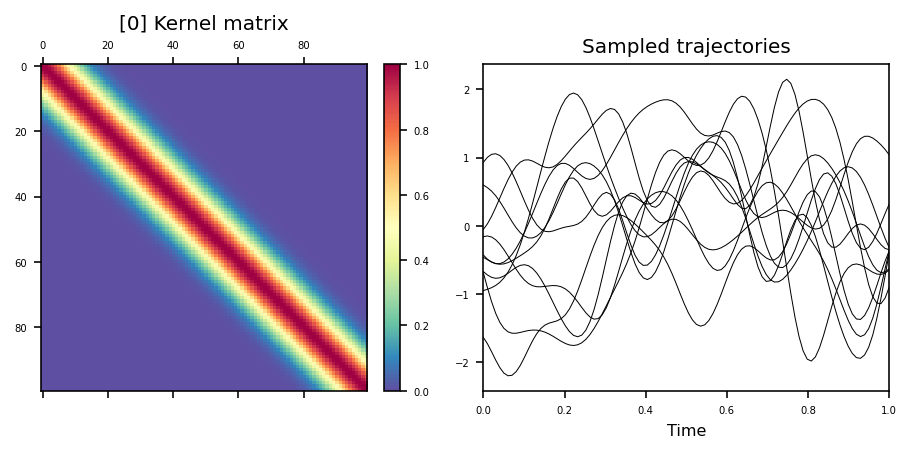

In [12]:
optm = torch.optim.Adam(model.parameters(),
                        lr=0.0001,betas=(0.9, 0.999),eps=1e-08)
L,D,BATCH_SIZE,MAX_ITER = 100,1,128,5000
x_0 # [D x L]
x_batch = torch.tile(x_0[None,:,:],dims=(BATCH_SIZE,1,1)) # [B x D x L]
# Different length parameters per dimension
lens = [0.1]
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
Ks_np,K_chols_np = np.zeros(shape=(D,L,L)),np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    K = kernel_se(times,times,hyp={'gain':1.0,'len':lens[d_idx]})
    Ks_np[d_idx,:,:] = K
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-10*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np) # [D x L x L]
# Plot kernel matrix and sampled trajectories
for d_idx in range(D):
    K = Ks_np[d_idx,:,:]
    K_chol = K_chols_np[d_idx,:,:]
    n_traj = 10
    trajs = np.random.randn(n_traj,L) @ K_chol.T # [n_traj x L]
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.matshow(K,fignum=False,cmap=plt.cm.Spectral_r)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('[%d] Kernel matrix'%(d_idx),fontsize=10)
    plt.subplot(1,2,2)
    for traj_idx in range(n_traj):
        plt.plot(times[:,0],trajs[traj_idx,:],ls='-',color='k',lw=1/2); 
    plt.xlim([0,1])
    plt.title('Sampled trajectories',fontsize=10)
    plt.xlabel('Time',fontsize=8); plt.show()

In [13]:
# Optimize
optm = torch.optim.Adam(
    model.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-06,weight_decay=1e-06)
model.train()
device = 'cpu'
for it in range(MAX_ITER):
    optm.zero_grad()
    t = torch.randint(0, dc['T'],(BATCH_SIZE,),device=device).long() # [B]
    loss = get_loss(model=model,x_0=x_batch,K_chols=K_chols,t=t,dc=dc)
    loss.backward()
    optm.step()
    if (it % 200) == 0:
        print ("[%d/%d] loss:[%.3f]"%(it,MAX_ITER,loss.item()))
print ("Done.")

[0/5000] loss:[0.416]
[200/5000] loss:[0.016]
[400/5000] loss:[0.005]
[600/5000] loss:[0.004]
[800/5000] loss:[0.004]
[1000/5000] loss:[0.002]
[1200/5000] loss:[0.002]
[1400/5000] loss:[0.002]
[1600/5000] loss:[0.001]
[1800/5000] loss:[0.002]
[2000/5000] loss:[0.003]
[2200/5000] loss:[0.001]
[2400/5000] loss:[0.001]
[2600/5000] loss:[0.001]
[2800/5000] loss:[0.003]
[3000/5000] loss:[0.002]
[3200/5000] loss:[0.003]
[3400/5000] loss:[0.001]
[3600/5000] loss:[0.001]
[3800/5000] loss:[0.001]
[4000/5000] loss:[0.001]
[4200/5000] loss:[0.000]
[4400/5000] loss:[0.001]
[4600/5000] loss:[0.001]
[4800/5000] loss:[0.000]
Done.


### Generation

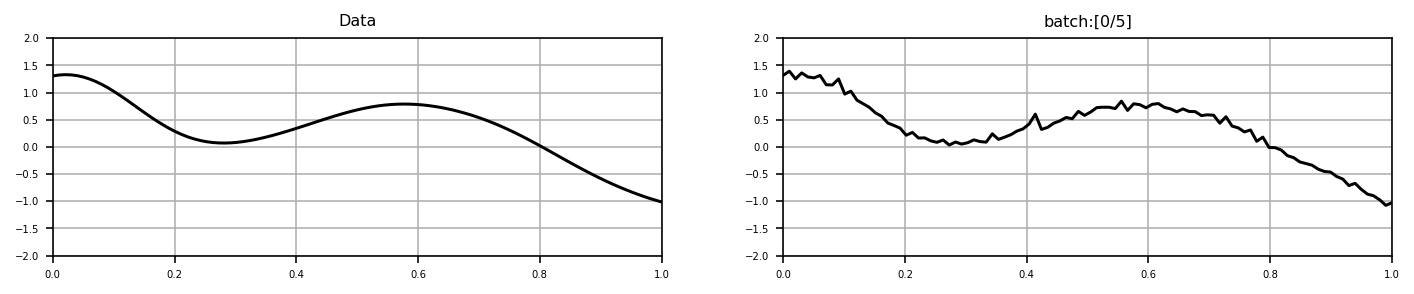

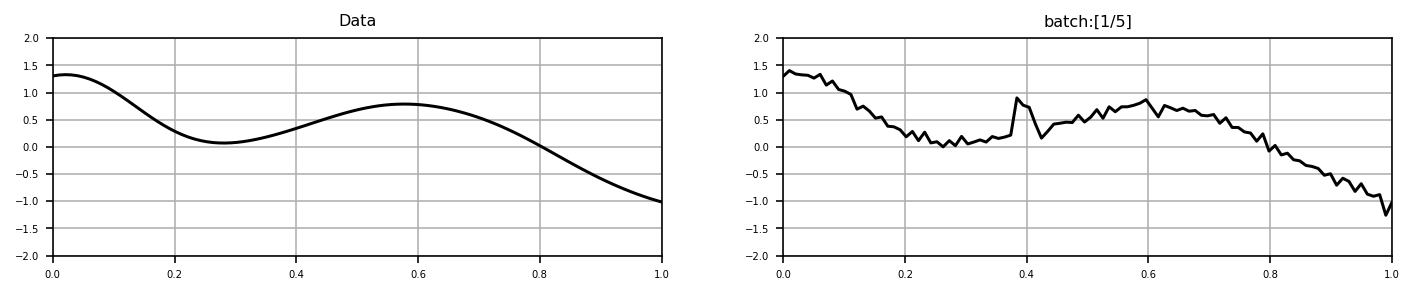

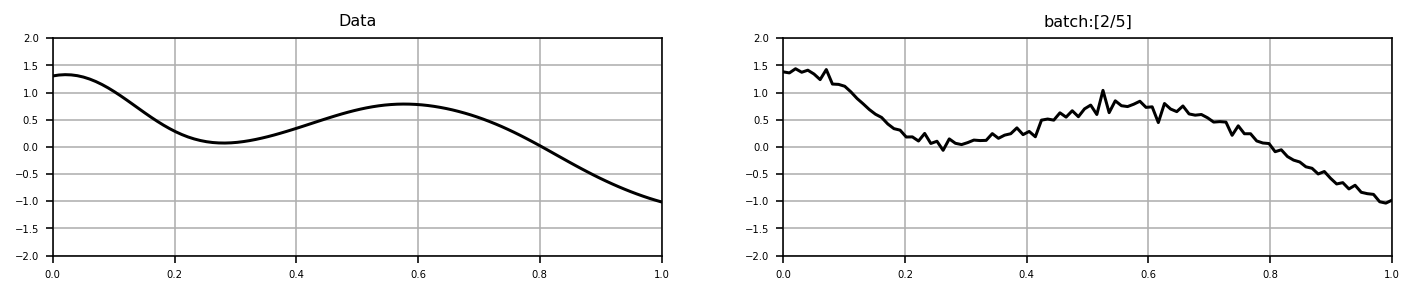

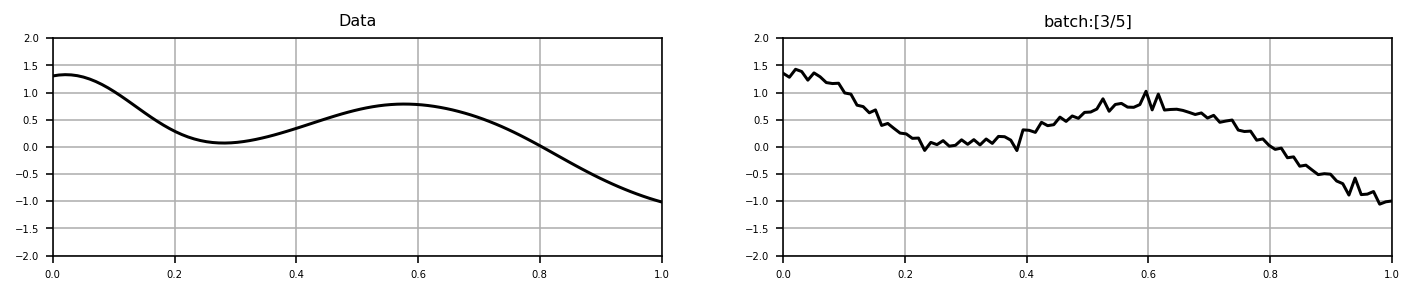

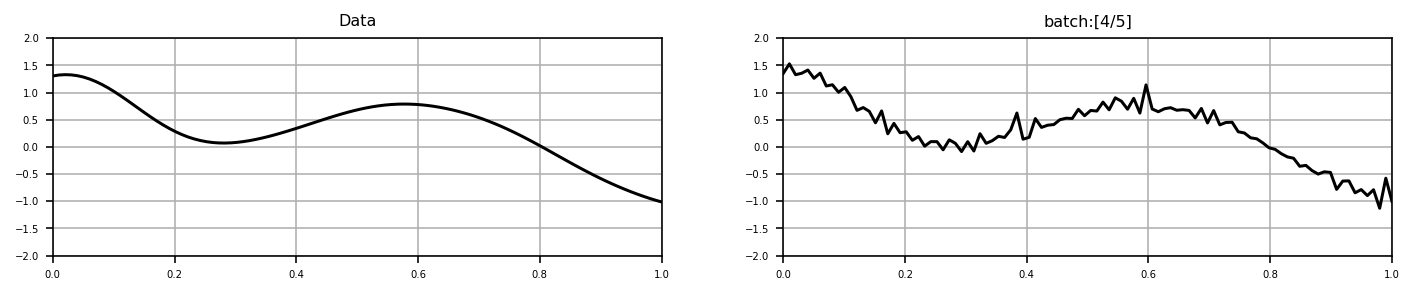

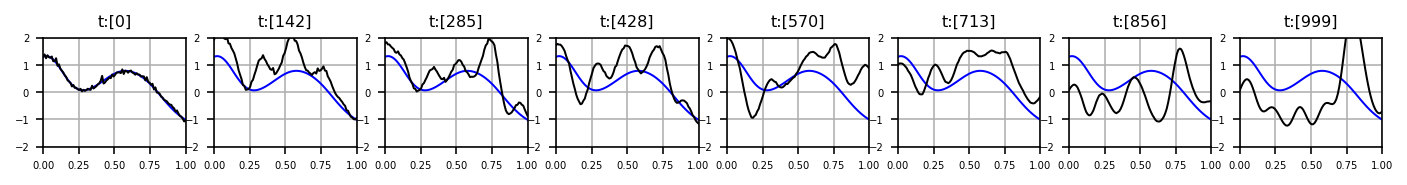

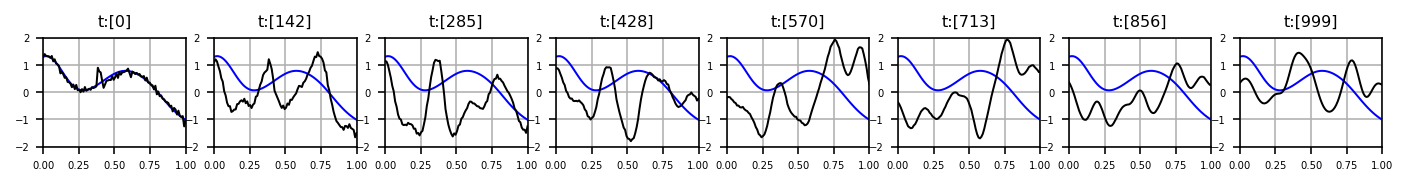

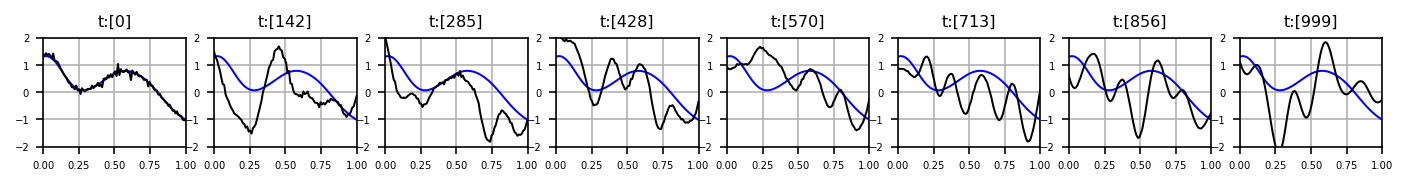

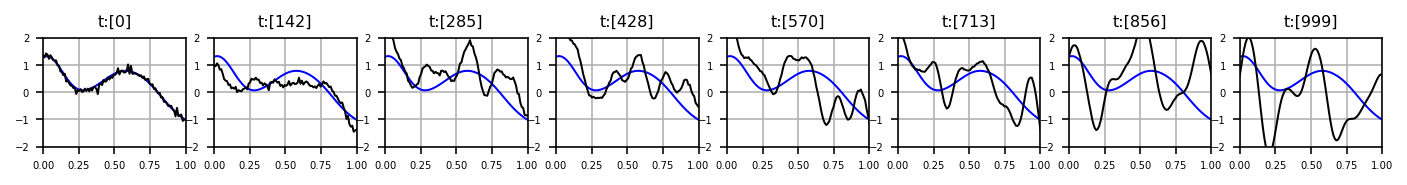

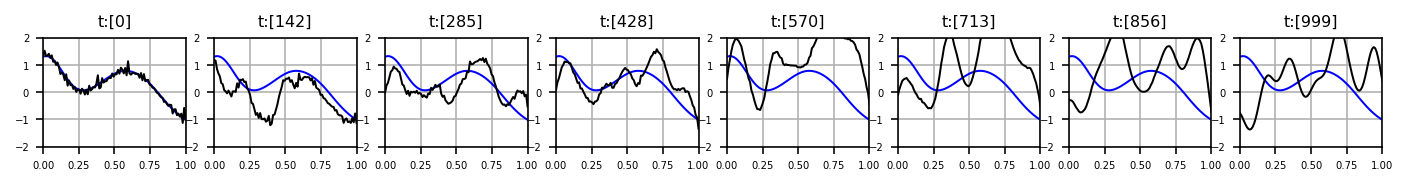

Ready.


In [15]:
model.eval()
device = 'cpu'
B,D,L = 5,1,100
model = model.to(device)
# Sample x_T from prior
x_0_dummy = np2torch(np.zeros((B,D,L)))
steps = torch.zeros(B).type(torch.long) # [B]
_,noise = forward_hilbert_diffusion_sample(
    x_0=x_0_dummy,K_chols=K_chols,steps=steps,dc=dc,noise_rate=1.0)
x_T = noise.clone() # [B x D x L]
x_t = x_T.clone()

# Generate
x_ts = ['']*dc['T']
for t in range(0,dc['T'])[::-1]:
    t_torch = torch.full((1,), t,device=device,dtype=torch.long)
    x_t # [B x D x L]
    # TODO: NEED TO TRANSPOSE NOT RESHAPE
    # x_t_flat = x_t.reshape(x_t.shape[0],-1) # [B x DL]
    x_t_flat = x_t.transpose(1, 2) # [B x L x D]
    eps_t = model(x=x_t_flat,y=None, t=t_torch) # [B x L X D]
    # TODO: NEED TO TRANSPOSE NOT RESHAPE
    # eps_t_unflat = eps_t.reshape_as(x_t) # [B x D x L]
    eps_t_unflat = eps_t.transpose(1, 2) # [B x D x L]
    # Diffusion constants
    betas_t = gather_and_reshape(
        values=dc['betas'],steps=t_torch,x_shape=x_t.shape) # [B x 1 x 1]
    sqrt_one_minus_alphas_bar_t = gather_and_reshape(
        values=dc['sqrt_one_minus_alphas_bar'],steps=t_torch,x_shape=x_t.shape)
    sqrt_recip_alphas_t = gather_and_reshape(
        values=dc['sqrt_recip_alphas'],steps=t_torch,x_shape=x_t.shape)
    # Compute posterior mean
    model_mean_t = sqrt_recip_alphas_t * (
        x_t - betas_t*eps_t_unflat/sqrt_one_minus_alphas_bar_t
    ) # [B x D x L]
    # Compute correlated noise
    x_0_dummy = np2torch(np.zeros((B,D,L)))
    steps = torch.zeros(B).type(torch.long) # [B]
    _,noise_t = forward_hilbert_diffusion_sample(
        x_0=x_0_dummy,K_chols=K_chols,steps=steps,dc=dc,noise_rate=1.0)
    noise_t # [B x D x L]
    # Compute posterior variance
    posterior_variance_t = gather_and_reshape(
        values=dc['posterior_variance'],steps=t_torch,x_shape=x_t.shape)
    # Sample
    if t == 0: # last sampling, use mean
        x_t = model_mean_t
    else:
        x_t = model_mean_t + torch.sqrt(posterior_variance_t) * noise_t
    # Append
    x_ts[t] = x_t # [B x D x L]
    
# Plot generated trajectories
for b_idx in range(B):
    plt.figure(figsize=(12,2))
    plt.subplot(1,2,1)
    plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='k'); plt.grid('on')
    plt.title('Data',fontsize=8); plt.xlim(0,+1); plt.ylim(-2,+2)
    plt.subplot(1,2,2)
    plt.plot(times[:,0],torch2np(x_t)[b_idx,0,:],ls='-',color='k'); plt.grid('on')
    plt.title('batch:[%d/%d]'%(b_idx,B),fontsize=8); plt.xlim(0,+1); plt.ylim(-2,+2)
    plt.show()
    
# Plot how the trajectories are generated
for b_idx in range(B):
    plt.figure(figsize=(12,1))
    M = 8
    for subplot_idx,t in enumerate(np.linspace(0,dc['T']-1,M).astype(np.int64)):
        plt.subplot(1,M,subplot_idx+1)
        x_t = x_ts[t][b_idx,:,:]
        plt.plot(times[:,0],torch2np(x_0)[0,:],ls='-',color='b',lw=1) # GT 
        plt.plot(times[:,0],torch2np(x_t)[0,:],ls='-',color='k',lw=1) # generated
        plt.xlim(0,+1); plt.ylim(-2,+2); plt.grid('on')
        plt.title('t:[%d]'%(t),fontsize=8)
    plt.show()
print ("Ready.")